In [1]:
#!/usr/bin/python
# -*- encoding: utf-8 -*-
'''
@File    :   采样的GIF生成结构png.ipynb
@Time    :   2024/05/25 18:27:03
@Author  :   Hengda.Gao
@Contact :   ghd@nudt.edu.com
@Desc    :   分割 采样的GIF 
             提取topo的第一帧
             若满足生成结构png
'''

import os
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


# 获取GIF文件路径并排序保证每次加载gif文件对应

In [2]:
# voronoi-50k数据集训练立即采样结果 （13，2） 5.0_0 
# voronoi-50k数据集训练1次采样结果 （13，10）5.0_1
# voronoi-50k数据集训练2次采样结果 （20，5）5.0_2
sample_dir = '/home/hengda/VideoMetamaterials/runs/debug-128/eval_target_w_5.0_2/step_200000/gifs'
if not sample_dir:
    raise ValueError('sample_dir is not defined')
output_dir = '/home/hengda/VideoMetamaterials/runs/debug-128/eval_target_w_5.0_2/step_200000/gifs-post'
Path(output_dir).mkdir(parents=True, exist_ok=True)
# 获取文件夹中的所有文件
file_path_list = []
for root, dirs, files in os.walk(sample_dir):
    for file in files:
        if file.endswith('.gif'):
            file_path = os.path.join(root, file)
            file_path_list.append(file_path)
print(file_path_list)          

['/home/hengda/VideoMetamaterials/runs/debug-128/eval_target_w_5.0_2/step_200000/gifs/prediction_channel_3.gif', '/home/hengda/VideoMetamaterials/runs/debug-128/eval_target_w_5.0_2/step_200000/gifs/prediction_channel_1.gif', '/home/hengda/VideoMetamaterials/runs/debug-128/eval_target_w_5.0_2/step_200000/gifs/prediction_channel_0.gif', '/home/hengda/VideoMetamaterials/runs/debug-128/eval_target_w_5.0_2/step_200000/gifs/prediction_channel_2.gif']


In [3]:
# 根据 file_path_list[0].split('.')[1].split('_')[-1] 排序
file_path_list = sorted(file_path_list, key=lambda x: int(x.split('.')[1].split('_')[-1]))
file_path_list # 0，1，2，3 依次表示 u_1,u_2,s_22,topo

['/home/hengda/VideoMetamaterials/runs/debug-128/eval_target_w_5.0_2/step_200000/gifs/prediction_channel_0.gif',
 '/home/hengda/VideoMetamaterials/runs/debug-128/eval_target_w_5.0_2/step_200000/gifs/prediction_channel_1.gif',
 '/home/hengda/VideoMetamaterials/runs/debug-128/eval_target_w_5.0_2/step_200000/gifs/prediction_channel_2.gif',
 '/home/hengda/VideoMetamaterials/runs/debug-128/eval_target_w_5.0_2/step_200000/gifs/prediction_channel_3.gif']

In [4]:
# 首先提取topo结构
topo_path = file_path_list[3]
# 加载gif图片
import imageio
topo = imageio.mimread(topo_path)
print('*'*100)
print(f'topo的帧数{len(topo)}')
# 提取每一帧
topo_frames = []
for i in range(len(topo)):
    topo_frames.append(topo[i])
print('每一帧的大小为')
print(topo_frames[0].shape)
print('*'*100)
# 一共有{}样本
sample_number = int(topo_frames[0].shape[0]/128)
print(f'一共有{sample_number}样本')
# 每个样本有{}种情况
shape_number = int(topo_frames[0].shape[1]/128)
print(f'每个样本有{shape_number}种情况')
print('*'*100)

****************************************************************************************************
topo的帧数11
每一帧的大小为
(2640, 660)
****************************************************************************************************
一共有20样本
每个样本有5种情况
****************************************************************************************************


In [5]:
# 分割成numpy数组
all_list = []
# 11帧
# for i in range(len(topo_frames)):
i= 0
sample = np.split(topo_frames[i], sample_number, axis=0)
for k in range(sample_number):   
    sample_list = [
    np.split(sample[k], shape_number, axis=1)[j][2:-2, 2:-2]
    for j in range(shape_number) 
    ]
    all_list.append(sample_list)
topo0 = np.array(all_list)
topo0.shape # 样本数，每个样本的形状数，每个形状的大小 topo0表示第0帧

(20, 5, 128, 128)

Text(0.5, 1.0, 'pixel distribution')

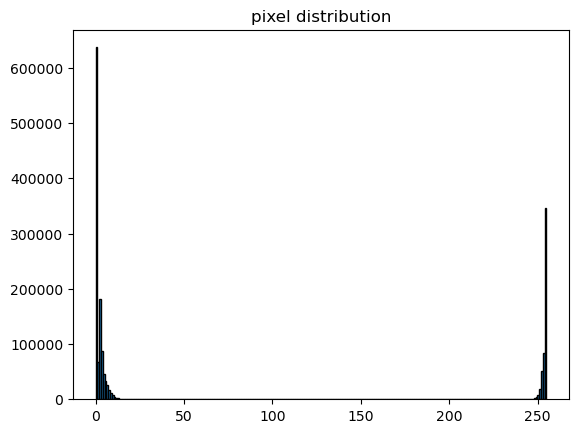

In [6]:
import matplotlib.pyplot as plt
plt.hist(topo0.flatten(), bins=250, edgecolor="k");
plt.title("pixel distribution")

In [7]:
def unique_count(array):
    # 查询样本不同元素的元素个数
    unique, counts = np.unique(array, return_counts=True)
    for i in range(len(counts)):
        print(f'unique:{unique[i]}, counts:{counts[i]}')

In [8]:
# 检测连通性，打印图片，以供仿真, 看是否需要改变尺寸
def check_connectivity(f_bar):
    import cv2
    binary_matrix = cv2.threshold(f_bar, 127, 155, cv2.THRESH_BINARY)[1]
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_matrix, connectivity=8)
    num_components = retval - 1  
    if num_components == 1: 
        return True
    else:
        print("*"*50)
        print(f'num_components:{num_components}')
        print("*"*50)
        return False

check_connectivity(topo0[0,1])

True

In [9]:
# 保存连通图片
def save_connectivity(topo0, output_dir):
    import cv2
    for i in range(topo0.shape[0]):
        for j in range(topo0.shape[1]):
            if check_connectivity(topo0[i,j]):
                cv2.imwrite(f'{output_dir}/topo_{i}_{j}.png', topo0[i,j])
            else:
                print(f'topo_{i}_{j}不连通')

In [10]:
save_connectivity(topo0, output_dir)

**************************************************
num_components:2
**************************************************
topo_1_3不连通
**************************************************
num_components:2
**************************************************
topo_2_3不连通
**************************************************
num_components:2
**************************************************
topo_5_1不连通
**************************************************
num_components:2
**************************************************
topo_6_4不连通
**************************************************
num_components:2
**************************************************
topo_10_3不连通
**************************************************
num_components:2
**************************************************
topo_11_0不连通
**************************************************
num_components:2
**************************************************
topo_11_2不连通
**************************************************
num_components:2
************

In [ ]:

# cv2.threshold 是 OpenCV 库中的一个函数，用于对图像进行阈值处理。它可以将图像转换为二值图像，根据指定的阈值将像素值分为两个类别。

# 该函数的参数如下：

# src：输入图像，可以是任何类型的单通道图像。
# thresh：阈值，用于将像素值分为两个类别。根据不同的阈值类型，像素值可以大于、小于或等于阈值。
# maxval：当像素值满足阈值条件时，赋予的新值。
# type：阈值类型，用于指定像素值与阈值之间的比较关系。可以选择以下类型之一：
# cv2.THRESH_BINARY：二值阈值化，大于阈值的像素值设为 maxval，小于等于阈值的像素值设为 0。
# cv2.THRESH_BINARY_INV：反二值阈值化，大于阈值的像素值设为 0，小于等于阈值的像素值设为 maxval。
# cv2.THRESH_TRUNC：截断阈值化，大于阈值的像素值设为阈值，小于等于阈值的像素值保持不变。
# cv2.THRESH_TOZERO：零阈值化，大于阈值的像素值保持不变，小于等于阈值的像素值设为 0。
# cv2.THRESH_TOZERO_INV：反零阈值化，大于阈值的像素值设为 0，小于等于阈值的像素值保持不变。
# dst：输出图像，与输入图像具有相同的大小和类型。如果未提供，则会创建一个新的图像。
# 该函数的返回值是一个元组，包含两个元素：

# 阈值：实际使用的阈值，可能与输入的阈值不完全相同。
# 输出图像：经过阈值处理后的图像。
# 下面是一个使用 cv2.threshold 函数的示例：